In [436]:
import sys
sys.path.append("..")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D  
import rbf_gauss
from scipy.io import savemat
from torch.optim import lr_scheduler
from DataProcessing import HankelMatrices
from Models import ModelKoopmanNARX, ModelNARXResnet, ModelNARX, ModelKoopman,ModelKoopmanResnet,ModelKoopmanNARXResnet

In [437]:
# Load multisine data from matlab
mat = scipy.io.loadmat("DataSets/u_data800sinsSweptAmpLarge.mat")
u_data = mat["u_data"]

mat = scipy.io.loadmat("DataSets/y_data800sinsSweptAmpLarge.mat")
y_data = mat["y_data"]

# convert data to tensors
u_data = np.array(u_data)
y_data = np.array(y_data)

u_data = torch.FloatTensor(u_data).transpose(0,1)
#u_data = u_data[0,:1000].unsqueeze(0).transpose(0,1)
y_data = torch.FloatTensor(y_data).transpose(0,1)
#y_data = y_data[0,:1000].unsqueeze(0).transpose(0,1)
#y_data = y_data[0,:].unsqueeze(1)
#torch.reshape(y_data,(1000, 1))
input_dim = list(u_data.shape)[1]
output_dim = list(y_data.shape)[1]
print(f"input_dim = {input_dim}")
print(f"output_dim = {output_dim}")

input_dim = 1
output_dim = 1


In [438]:
# Hyper parameters
T_ini = 3
nbasisKoopman = 80
nbasisNARX = 20
T = y_data.shape[0]
N = 10
KoopmanBasis = 'gaussian'
NARXBasis = 'gaussian'
DataShuffle = False
norm_data = True

#Type of model
Modeltype = 'KoopmanResnet'
ModelString = 'Model'+Modeltype

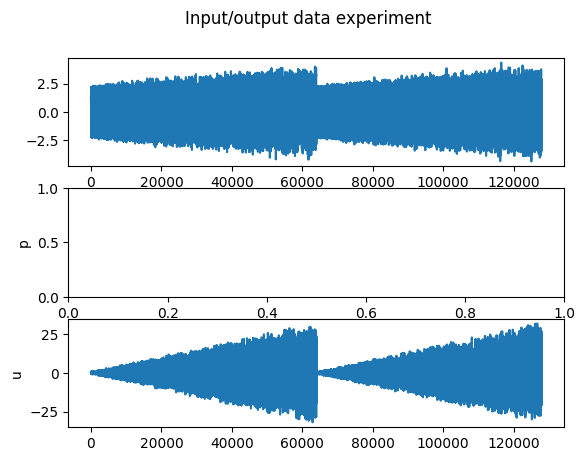

<Figure size 640x480 with 0 Axes>

In [439]:
# Plot the pendulum trajectory together with the input
fig, axs = plt.subplots(3)
fig.suptitle("Input/output data experiment")
axs[0].plot(y_data[:,])
#axs[1].plot(y_data[:,1])
axs[2].plot(u_data)
axs[1].set(ylabel="p")
#axs[1].set(ylabel="theta")
axs[2].set(ylabel="u")
plt.show()

plt.savefig('destination_path.eps', format='eps')

In [440]:

u_data_train = u_data[0:round(0.8*T)]
y_data_train = y_data[0:round(0.8*T)]
U_ini, Y_ini,U_0_Nm1, Y_1_N = HankelMatrices(u_data_train,y_data_train,T_ini,N,round(0.8*T) , input_dim, output_dim )

X_train = torch.cat((U_ini, Y_ini, U_0_Nm1), 1)
y_train = Y_1_N


u_data_test = u_data[round(0.8*T):T]
y_data_test = y_data[round(0.8*T):T]
U_ini, Y_ini,U_0_Nm1, Y_1_N = HankelMatrices(u_data_test,y_data_test,T_ini,N,round(0.2*T) , input_dim, output_dim )

X_test = torch.cat((U_ini, Y_ini, U_0_Nm1), 1)
y_test = Y_1_N


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [441]:
X_train_std = torch.std(X_train, dim=0)    # Calculate the standard deviation for each feature
X_train.shape

torch.Size([102387, 15])

In [442]:
# create a manual seed for randomization
torch.manual_seed(41)
# Create an instance of our model
if Modeltype == "Koopman":
    model = ModelKoopman(T_ini, N,nbasisKoopman, input_dim, output_dim, KoopmanBasis)
elif Modeltype == "KoopmanResnet":
    model = ModelKoopmanResnet(T_ini, N,nbasisKoopman, input_dim, output_dim, KoopmanBasis)
elif Modeltype == "KoopmanNARX":
    model = ModelKoopmanNARX(T_ini, N,nbasisKoopman,nbasisNARX, input_dim, output_dim, KoopmanBasis, NARXBasis)
elif Modeltype == "KoopmanNARXResnet":
    model = ModelKoopmanNARXResnet(T_ini, N,nbasisKoopman,nbasisNARX, input_dim, output_dim, KoopmanBasis, NARXBasis)  
elif Modeltype == "NARX":
    model = ModelNARX(T_ini, N,nbasisNARX, input_dim, output_dim, NARXBasis) 
elif Modeltype == "NARXResnet":
    model = ModelNARX(T_ini, N,nbasisNARX, input_dim, output_dim, NARXBasis) 


# Set the criterion for our model to measure the error
criterion = nn.MSELoss()
# Choose Adam optimizer, lr = Learning rate
optimizer = torch.optim.NAdam(model.parameters(), lr=1e-1, weight_decay=5e-6)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[1000,5000,12000], gamma=0.1)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
y_train= y_train.to(device)
X_train = X_train.to(device)
X_test = X_test.to(device)

# Normalizing the data
X_train_mean = torch.mean(X_train, dim=0)  # Calculate the mean for each feature
X_train_std = torch.std(X_train, dim=0)    # Calculate the standard deviation for each feature

if norm_data == True:
    print("Normalizing data:")
    X_train = (X_train - X_train_mean) / X_train_std
    print(f"Variance: {(torch.var(X_train))}")
    # Normalize X_test using the SAME mean and std calculated from the training data
    X_test = (X_test - X_train_mean) / X_train_std 

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 20000
losses = []
Vallosses = []
GradNormWeight = []
GradNormLinear = []
GradNormNL = []

for i in range(epochs):
    # Go forward and get a prediction
    y_pred = model.forward(X_train)  # get results
    #print(f"y_pred = {(y_pred).shape}")
    # Measure the loss/error,
    loss = criterion(y_pred, y_train)

    # keep track of our losses
    losses.append(loss.cpu().detach().numpy())

    with torch.no_grad():  # turn off backpropagation
        y_eval = model.forward(X_test) # are features from our test set
        Val_loss = criterion(y_eval, y_test.to(device))  # Find the loss or error
        Vallosses.append(Val_loss.cpu().detach().numpy())
    # print every 10 epoch
    if i % 10 == 0:
        print(f"Epoch: {i} and the loss: {loss}, Validation Loss: {Val_loss}")
    # Do some back propagation
    optimizer.zero_grad()
    loss.backward()
    for name, param in model.named_parameters():
        if name == 'l_2.weight':
            grad_magnitude = param.grad.norm()  # Calculate the norm (magnitude) of the gradient
            GradNormWeight.append(grad_magnitude.cpu().detach().numpy().item())
        if name == 'RBFKoopman.centers':
            grad_magnitude = param.grad.norm()  # Calculate the norm (magnitude) of the gradient
            GradNormLinear.append(grad_magnitude.cpu().detach().numpy().item())
        if name == 'RBFBFNARXBasis.centers':
            grad_magnitude = param.grad.norm()  # Calculate the norm (magnitude) of the gradient
            GradNormNL.append(grad_magnitude.cpu().detach().numpy().item())
    optimizer.step()
    scheduler.step()




Normalizing data:
Variance: 0.9999909400939941
Epoch: 0 and the loss: 77.18473052978516, Validation Loss: 22.731761932373047
Epoch: 10 and the loss: 0.9676547646522522, Validation Loss: 1.0738837718963623
Epoch: 20 and the loss: 0.6512402892112732, Validation Loss: 0.6743571758270264
Epoch: 30 and the loss: 0.5662720799446106, Validation Loss: 0.5819295644760132
Epoch: 40 and the loss: 0.5018740892410278, Validation Loss: 0.5229362845420837
Epoch: 50 and the loss: 0.4449767768383026, Validation Loss: 0.4717918038368225
Epoch: 60 and the loss: 0.39492523670196533, Validation Loss: 0.42816752195358276
Epoch: 70 and the loss: 0.3569500744342804, Validation Loss: 0.4028944671154022
Epoch: 80 and the loss: 0.3206775486469269, Validation Loss: 0.37694281339645386
Epoch: 90 and the loss: 0.29397451877593994, Validation Loss: 0.35982581973075867
Epoch: 100 and the loss: 0.26281899213790894, Validation Loss: 0.3313806354999542
Epoch: 110 and the loss: 0.24027764797210693, Validation Loss: 0.320

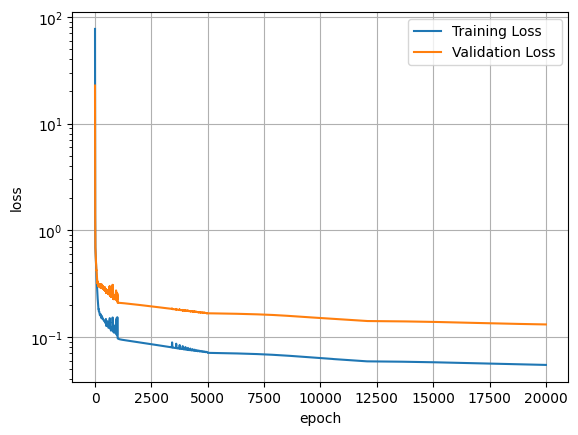

<Figure size 640x480 with 0 Axes>

In [443]:
# create a plot
plt.figure()
plt.semilogy(range(epochs), losses)
plt.semilogy(range(epochs), Vallosses)
plt.grid()
plt.legend(("Training Loss", "Validation Loss"))
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

if Modeltype== "Koopman":
    plt.savefig("TrainingLoss/"+str(model.RBFKoopman.basis_func)[23:-23]+'TrainingLoss_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_Loss'+str(round(loss.item(),4))+'_Koopman'+str(model.RBFKoopman.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype  == "KoopmanResnet":
    plt.savefig("TrainingLoss/"+str(model.RBFKoopman.basis_func)[23:-23]+'TrainingLoss_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_Loss'+str(round(loss.item(),4))+'_Koopman'+str(model.RBFKoopman.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "KoopmanNARX":
    plt.savefig("TrainingLoss/"+str(model.RBFKoopman.basis_func)[23:-23]+'TrainingLoss_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(loss.item(),4))+'_Koopman_'+str(model.RBFKoopman.basis_func)[23:-22]+'_NARX_'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "KoopmanNARXResnet":
    plt.savefig("TrainingLoss/"+str(model.RBFKoopman.basis_func)[23:-23]+'TrainingLoss_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(loss.item(),4))+'_Koopman_'+str(model.RBFKoopman.basis_func)[23:-22]+'_NARX_'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "NARX":
    plt.savefig("TrainingLoss/"+str(model.RBFNARXBasis.basis_func)[23:-23]+'TrainingLoss_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(loss.item(),4))+'_NARX'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "NARXResnet":
    plt.savefig("TrainingLoss/"+str(model.RBFNARXBasis.basis_func)[23:-23]+'TrainingLoss_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(loss.item(),4))+'_NARX_'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')


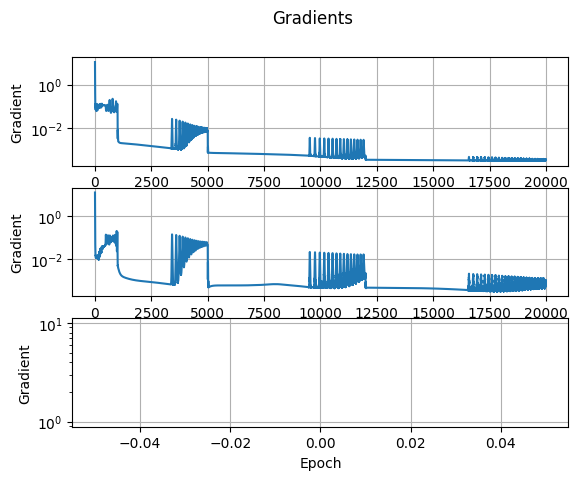

In [444]:
fig, axs = plt.subplots(3)
fig.suptitle("Gradients")
axs[0].semilogy(GradNormWeight, label="Weight")
axs[0].set(ylabel="Gradient",xlabel = 'Epoch')
axs[0].grid()
axs[1].semilogy(GradNormLinear, label="Linear")
axs[1].set(ylabel="Gradient",xlabel = 'Epoch')
axs[1].grid()
axs[2].semilogy(GradNormNL, label="NL")
axs[2].set(ylabel="Gradient",xlabel = 'Epoch')
axs[2].grid()
#fig.savefig('Gradients/Figures/LayerGradients'+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(loss.item(),4))+'_'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')

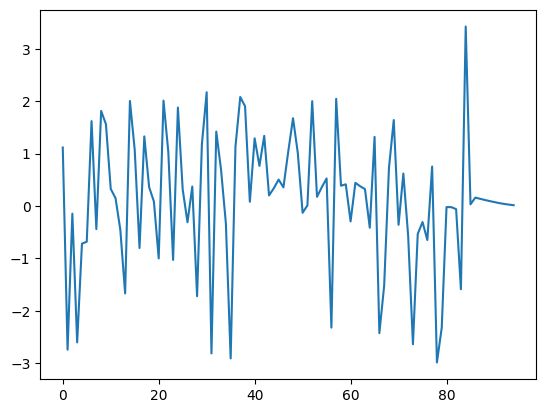

In [445]:
plt.plot(np.mean(model.l_2.weight.cpu().detach().numpy().astype(np.float64),0))

In [446]:
# evaluate the model on the test data set
# X_test_1 = X_test_1.to(device)
# X_test_2 = X_test_2.to(device)
# y_test = y_test.to(device)
with torch.no_grad():  # turn off backpropagation
    y_eval = model.cpu().forward(X_test.cpu())  # are features from our test set
    loss = criterion(y_eval, y_test)  # Find the loss or error


# Convert the model parameters to numpy arrays
# centersKoopman = model.RBFKoopman.centers.detach().cpu().numpy().astype(np.float64)
# sigmasKoopman = model.RBFKoopman.log_sigmas.detach().cpu().numpy().astype(np.float64)
# centersNARX= model.RBFFullBasis.centers.detach().cpu().numpy().astype(np.float64)
# sigmasNARX = model.RBFFullBasis.log_sigmas.detach().cpu().numpy().astype(np.float64)
weight = model.l_2.weight.cpu().detach().numpy().astype(np.float64)
data_mean = X_train_mean.cpu().detach().numpy().astype(np.float64)
data_std = X_train_std.cpu().detach().numpy().astype(np.float64)
#bias = model.l_2.bias.cpu().detach().numpy().astype(np.float64)


if Modeltype == "Koopman":
    centersKoopman = model.RBFKoopman.centers.detach().cpu().numpy().astype(np.float64)
    sigmasKoopman = model.RBFKoopman.log_sigmas.detach().cpu().numpy().astype(np.float64)
    savemat(
        "RBFs/"+str(model.RBFKoopman.basis_func)[23:-23]+"/RBF_Params_Koopman"+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_KoopmanBasis_'+str(model.RBFKoopman.basis_func)[23:-23]+".mat",
        {'centersKoopman': centersKoopman, 'log_sigmasKoopman': sigmasKoopman,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

elif Modeltype == "KoopmanNARX":
    centersKoopman = model.RBFKoopman.centers.detach().cpu().numpy().astype(np.float64)
    sigmasKoopman = model.RBFKoopman.log_sigmas.detach().cpu().numpy().astype(np.float64)
    centersNARX= model.RBFNARXBasis.centers.detach().cpu().numpy().astype(np.float64)
    sigmasNARX = model.RBFNARXBasis.log_sigmas.detach().cpu().numpy().astype(np.float64)
    savemat(
        "RBFs/"+str(model.RBFKoopman.basis_func)[23:-23]+"/"+str(model.RBFNARXBasis.basis_func)[23:-23]+"/RBF_Params_KoopmanNARX"+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_nbasisFullBasis'+str(nbasisNARX)+'_N'+str(N)+'_KoopmanBasis_'+str(model.RBFKoopman.basis_func)[23:-23]+'_FullBasis_'+str(model.RBFNARXBasis.basis_func)[23:-23]+".mat",
        {'centersKoopman': centersKoopman,'centersNARX': centersNARX, 'log_sigmasKoopman': sigmasKoopman, 'log_sigmasNARX': sigmasNARX, 'data_mean': data_mean, 'data_std': data_std, 'weight': weight})
    
elif Modeltype == "KoopmanNARXResnet":
    centersKoopman = model.RBFKoopman.centers.detach().cpu().numpy().astype(np.float64)
    sigmasKoopman = model.RBFKoopman.log_sigmas.detach().cpu().numpy().astype(np.float64)
    centersNARX= model.RBFNARXBasis.centers.detach().cpu().numpy().astype(np.float64)
    sigmasNARX = model.RBFNARXBasis.log_sigmas.detach().cpu().numpy().astype(np.float64)
    savemat(
        "RBFs/"+str(model.RBFKoopman.basis_func)[23:-23]+"/"+str(model.RBFNARXBasis.basis_func)[23:-23]+"/RBF_Params_KoopmanNARXResnet"+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_nbasisFullBasis'+str(nbasisNARX)+'_N'+str(N)+'_KoopmanBasis_'+str(model.RBFKoopman.basis_func)[23:-23]+'_FullBasis_'+str(model.RBFNARXBasis.basis_func)[23:-23]+".mat",
        {'centersKoopman': centersKoopman,'centersNARX': centersNARX, 'log_sigmasKoopman': sigmasKoopman, 'log_sigmasNARX': sigmasNARX, 'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

elif Modeltype == "KoopmanResnet":
    centersKoopman = model.RBFKoopman.centers.detach().cpu().numpy().astype(np.float64)
    sigmasKoopman = model.RBFKoopman.log_sigmas.detach().cpu().numpy().astype(np.float64)
    savemat(
        "RBFs/"+str(model.RBFKoopman.basis_func)[23:-23]+"/RBF_Params_KoopmanResnet"+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_KoopmanBasis_'+str(model.RBFKoopman.basis_func)[23:-23]+".mat",
        {'centersKoopman': centersKoopman, 'log_sigmasKoopman': sigmasKoopman,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

elif Modeltype == "NARX":
    centersNARX= model.RBFNARXBasis.centers.detach().cpu().numpy().astype(np.float64)
    sigmasNARX = model.RBFNARXBasis.log_sigmas.detach().cpu().numpy().astype(np.float64)
    savemat(
        "RBFs/"+str(model.RBFNARXBasis.basis_func)[23:-23]+"/RBF_Params_NARX"+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_NARXBasis_'+str(model.RBFNARXBasis.basis_func)[23:-23]+".mat",
        {'centersNARX': centersNARX, 'log_sigmasNARX': sigmasNARX,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})    

elif Modeltype == "NARXResnet":
    centersNARX= model.RBFNARXBasis.centers.detach().cpu().numpy().astype(np.float64)
    sigmasNARX = model.RBFNARXBasis.log_sigmas.detach().cpu().numpy().astype(np.float64)
    savemat(
        "RBFs/"+str(model.RBFNARXBasis.basis_func)[23:-23]+"/RBF_Params_NARXResnet"+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_NARXBasis_'+str(model.RBFNARXBasis.basis_func)[23:-23]+".mat",
        {'centersNARX': centersNARX, 'log_sigmasNARX': sigmasNARX,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

# #KoopmanResnet
# savemat(
#     "RBFs/"+str(model.RBFKoopman.basis_func)[23:-23]+"/RBF_Params_KoopmanResnet"+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_KoopmanBasis_'+str(model.RBFKoopman.basis_func)[23:-23]+".mat",
#     {'centersKoopman': centersKoopman, 'log_sigmasKoopman': sigmasKoopman,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

#Koopman
# savemat(
#     "RBFs/"+str(model.RBFKoopman.basis_func)[23:-23]+"/RBF_Params_Koopman"+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_KoopmanBasis_'+str(model.RBFKoopman.basis_func)[23:-23]+".mat",
#     {'centersKoopman': centersKoopman, 'log_sigmasKoopman': sigmasKoopman,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

# #NARXResnet
# savemat(
#     "RBFs/"+str(model.RBFNARXBasis.basis_func)[23:-23]+"/RBF_Params_NARXResnet"+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_NARXBasis_'+str(model.RBFNARXBasis.basis_func)[23:-23]+".mat",
#     {'centersNARX': centersNARX, 'log_sigmasNARX': sigmasNARX,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

#NARX
# savemat(
#     "RBFs/"+str(model.RBFFULLBasis.basis_func)[23:-23]+"/RBF_Params_NARX"+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_NARXBasis_'+str(model.RBFNARXBasis.basis_func)[23:-23]+".mat",
#     {'centersNARX': centersNARX, 'log_sigmasNARX': sigmasNARX,  'data_mean': data_mean, 'data_std': data_std, 'weight': weight})

# savemat(
#     "RBFs/"+str(model.RBFnon_linear.basis_func)[23:-23]+"/RBF_Params_MIXED"+'_Tini'+str(T_ini)+'_nbasis'+str(n_basis)+'_N'+str(N)+'_'+str(model.RBFnon_linear.basis_func)[23:-23]+".mat",
#     {'centersL': centersL,'centersNL': centersNL, 'log_sigmasL': sigmasL, 'log_sigmasNL': sigmasNL, 'data_mean': data_mean, 'data_std': data_std, 'weight': weight,'bias': bias})




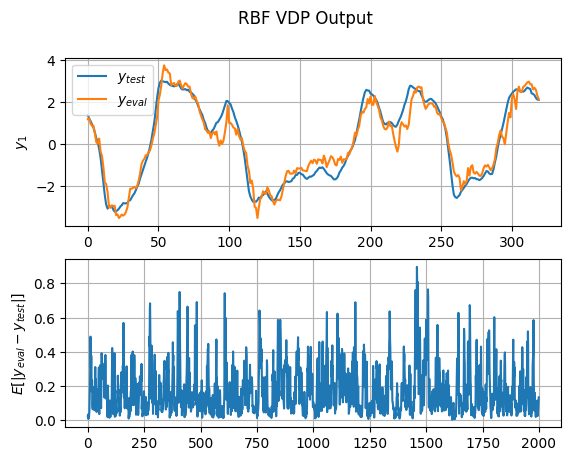

In [447]:


Error = np.mean(np.abs(y_eval.cpu().detach().numpy()  - y_test.cpu().detach().numpy()),1)

fig, axs = plt.subplots(2)
fig.suptitle("RBF VDP Output")
axs[0].plot(y_test.cpu()[180:500,N-1], label="$y_{test}$")
axs[0].plot(y_eval[180:500,N-1].cpu().detach().numpy(), label = "$y_{eval}$")
axs[0].legend()
axs[0].grid()

axs[1].plot(Error[:2000])
axs[0].set(ylabel="$y_1$")
#axs[1].set(ylabel="theta")
axs[1].set(ylabel="$E[|y_{eval}-y_{test}|]$")
axs[1].grid()
plt.show()


if Modeltype == "Koopman":
    fig.savefig('RBFs/'+str(model.RBFKoopman.basis_func)[23:-23]+'/Validation/Validation_plot_Koopman_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_Loss'+str(round(Val_loss.item(),4))+'_Koopman'+str(model.RBFKoopman.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "KoopmanResnet":
    fig.savefig('RBFs/'+str(model.RBFKoopman.basis_func)[23:-23]+'/Validation/Validation_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_N'+str(N)+'_Loss'+str(round(Val_loss.item(),4))+'_Koopman'+str(model.RBFKoopman.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "KoopmanNARX":
    fig.savefig('RBFs/'+str(model.RBFKoopman.basis_func)[23:-23]+'/Validation/Validation_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(Val_loss.item(),4))+'_Koopman_'+str(model.RBFKoopman.basis_func)[23:-22]+'_NARX_'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "KoopmanNARXResnet":
    fig.savefig('RBFs/'+str(model.RBFKoopman.basis_func)[23:-23]+'/Validation/Validation_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisKoopman'+str(nbasisKoopman)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(Val_loss.item(),4))+'_Koopman_'+str(model.RBFKoopman.basis_func)[23:-22]+'_NARX_'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "NARX":
    fig.savefig('RBFs/'+str(model.RBFNARXBasis.basis_func)[23:-23]+'/Validation/Validation_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(Val_loss.item(),4))+'_NARX'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')
elif Modeltype == "NARXResnet":
    fig.savefig('RBFs/'+str(model.RBFNARXBasis.basis_func)[23:-23]+'/Validation/Validation_plot_'+Modeltype+'_Tini'+str(T_ini)+'_nbasisNARX'+str(nbasisNARX)+'_N'+str(N)+'_Loss'+str(round(Val_loss.item(),4))+'_NARX_'+str(model.RBFNARXBasis.basis_func)[23:-22]+ '.png', format='png')

